# Setup

In [ ]:
!pip install torchaudio datasets librosa torchlibrosa ftfy braceexpand wget webdataset wandb --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   

In [ ]:
#@title Mount drive & Clone GitHub
import os, shutil, getpass
from google.colab import drive

update_drive_copy = True #@param {type:"boolean"}

REPO_NAME = "Audio-ResiDual"
DRIVE_DIR_NAME = 'Progetto Deep' #@param {type:"string"}
DRIVE_PATH = '/content/drive/MyDrive/' + DRIVE_DIR_NAME + '/'
TARGET_DIR = os.path.join(DRIVE_PATH, REPO_NAME)

drive.mount('/content/drive')

GITHUB_USER = "arianna011" #@param {type: "string"}

if update_drive_copy or not os.path.exists(TARGET_DIR):
  GITHUB_URL = f"https://github.com/{GITHUB_USER}/{REPO_NAME}.git"
  TEMP_CLONE_DIR = f"/content/{REPO_NAME}"

  if os.path.exists(TEMP_CLONE_DIR):
      shutil.rmtree(TEMP_CLONE_DIR)

  print(f"Cloning {REPO_NAME} into Colab RAM...")
  exit_code = os.system(f'git clone "{GITHUB_URL}" "{TEMP_CLONE_DIR}"')

  if exit_code == 0:
      print(f"Copying to Google Drive into {TARGET_DIR}")
      if os.path.exists(TARGET_DIR):
          shutil.rmtree(TARGET_DIR)
      shutil.copytree(TEMP_CLONE_DIR, TARGET_DIR)
      print("Done")
  else:
      print("Clone failed")

CLAP_path = os.path.join(TARGET_DIR, "CLAP")
ResiDual_path = os.path.join(TARGET_DIR, "ResiDual")
%cd "{TARGET_DIR}"
!ls

Mounted at /content/drive
Cloning Audio-ResiDual into Colab RAM...
Copying to Google Drive into /content/drive/MyDrive/Progetto Deep/Audio-ResiDual
Done
/content/drive/MyDrive/Progetto Deep/Audio-ResiDual
1_Analyze_CLAP_Attention.ipynb		       CLAP		ResiDual
2_Apply_ResiDual_on_CLAP.ipynb		       data_processing	src
3_Evaluate_and_compare_CLAP_performance.ipynb  README.md


In [ ]:
#@title Imports
import torch
import os
from tqdm import tqdm
import pandas as pd
import librosa
import IPython.display as ipd
import math, random
import torchaudio
from torchaudio import transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import gc
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.nn as nn
import wandb
from data_processing import AudioDataset, get_dataframe, DATASETS, get_fold_dataloaders
from CLAP.src.laion_clap import htsat, model, CLAP_Module
from CLAP.src import get_audio_features
from src import residual as res
from src import training as T

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

# Apply ResiDual to CLAP

In this notebook, an attempt is made to apply the ResiDual method (https://arxiv.org/pdf/2411.00246) to the CLAP **HTSAT audio encoder**.

In particular, given a list $Layers$ of Swin transformer layers in which to inject ResiDual:
- attention representations $R^A_{l,i}$ are collected from each block $i \in depth_l$ for each $l \in Layers$ and aggregated in $R^A_l$ by concatenation on the sequence length dimension;

- PCA is applied on $R^A_l$ to obtain a corresponding basis $\phi$ and a mean $\mu$;

- the original ResiDual anisotropic rescaling is applied: \\
$RD_{\phi, \mu} (R^A_l, \lambda) = \phi ^{-1} \ diag(\lambda) \ \phi \ (R^A_l \ - \mu)^T \ = Y^A_l$;

- the output $Y^A_l$ from each layer $l \in Layers$ is injected in the transformer residual in place of $R^A_l$ in order to train the learnable parameter $\lambda$.

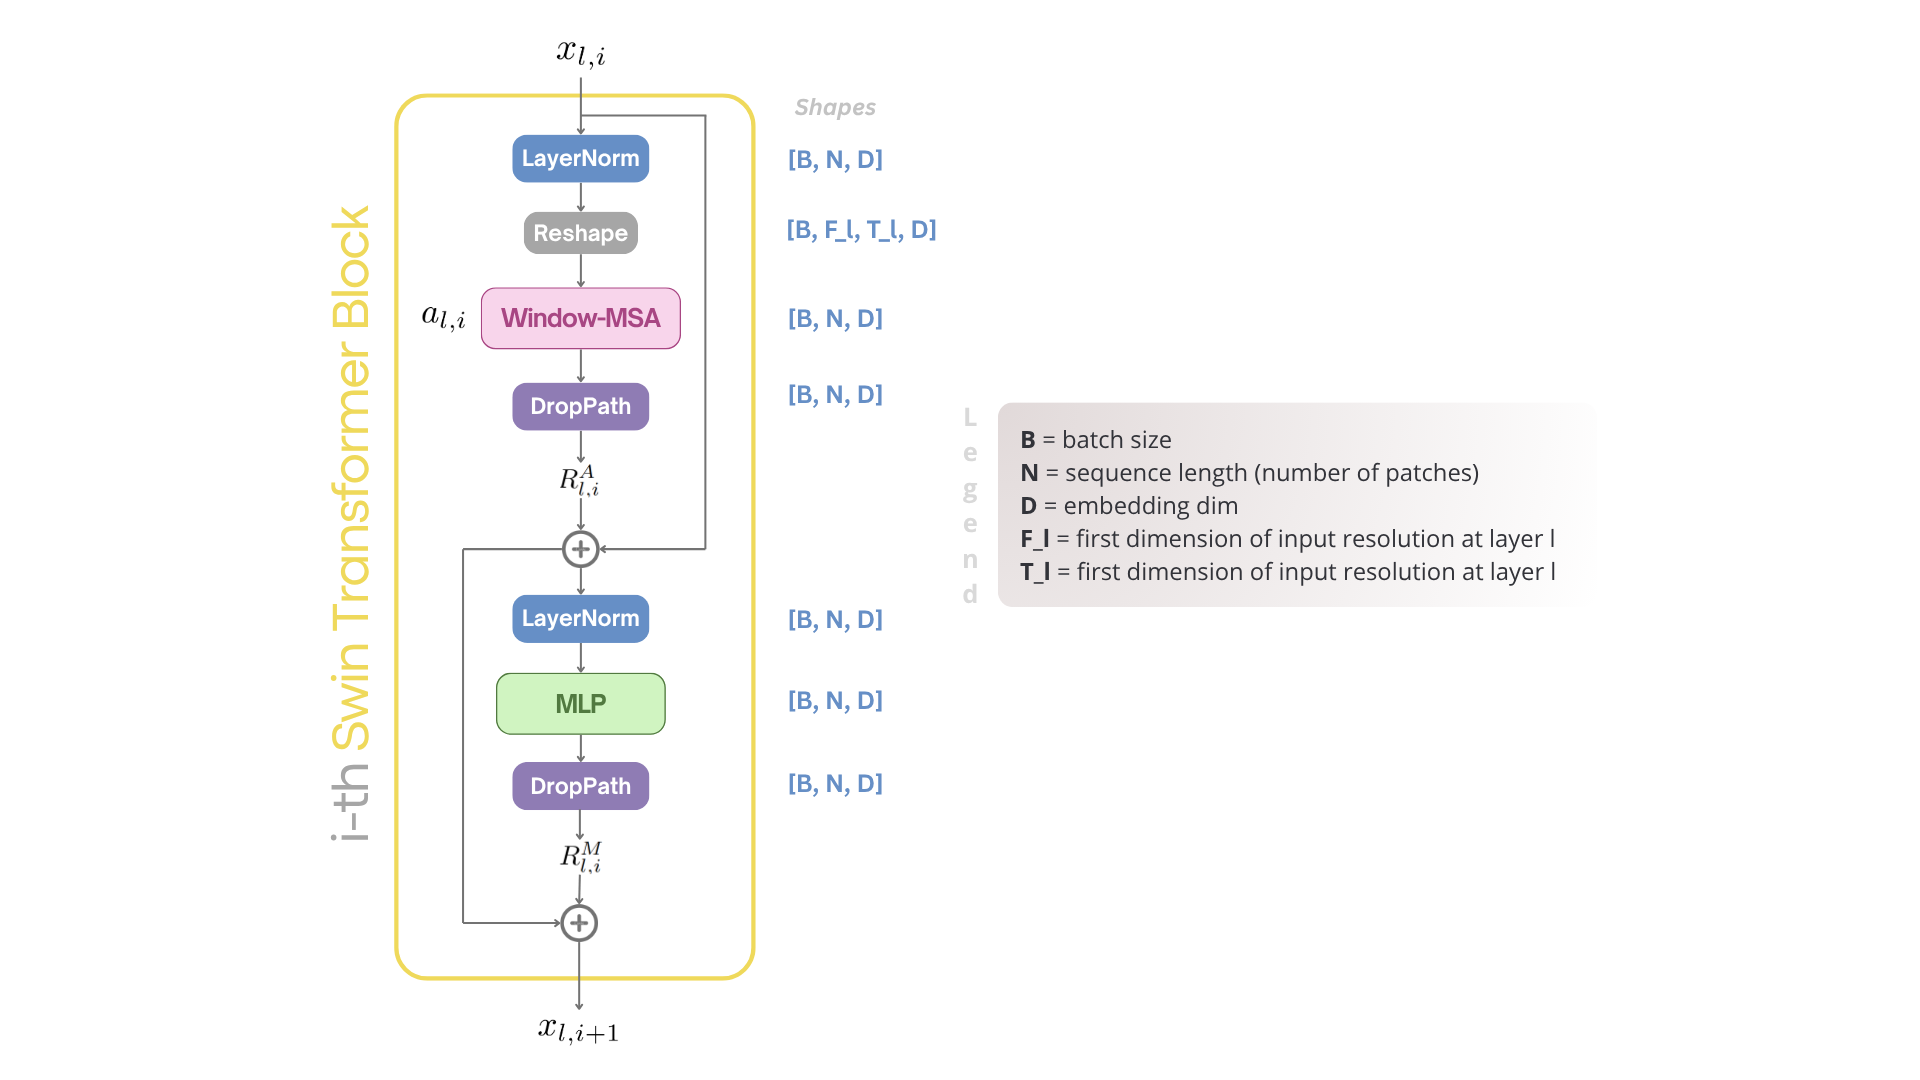

In [ ]:
#@title Load dataset
DATASET = 'ESC50' #@param ['ESC50', 'UrbanSound8K']
batch_sz = 64 #@param {type:"slider", min:1, max:256, step:1}
audio_dir = os.path.join(TARGET_DIR, DATASETS[DATASET]["audio_dir"])
dataset = AudioDataset(DATASET, get_dataframe(DATASET, cwd=TARGET_DIR), audio_dir)
fold_dataloaders = get_fold_dataloaders(dataset, batch_size = batch_sz)

Download complete.
ZIP extraction complete.


### Load HTSAT

In [ ]:
clap = CLAP_Module(enable_fusion=False)
clap.load_ckpt() # download default pretrained checkpoint

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Inject Residual

### Pre-compute PCA basis and mean

In [ ]:
for i,(train_load, val_load) in enumerate(fold_dataloaders):
  print(f'===== ITERATION {i} =====')
  for l in range(len(audio_encoder.layers)):
    save_path = os.path.join(DRIVE_PATH, "residual_pca", DATASET, f"layer_{l}_evalfold_{i}")
    res.compute_pca_components(clap, train_load, l, save_path=save_path)

===== ITERATION 0


Applying PCA on layer 0: 100%|██████████| 25/25 [06:46<00:00, 16.25s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_0_evalfold_0


Applying PCA on layer 1: 100%|██████████| 25/25 [04:03<00:00,  9.74s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_1_evalfold_0


Applying PCA on layer 2: 100%|██████████| 25/25 [05:48<00:00, 13.94s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_2_evalfold_0


Applying PCA on layer 3: 100%|██████████| 25/25 [02:20<00:00,  5.62s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_3_evalfold_0
===== ITERATION 1


Applying PCA on layer 0: 100%|██████████| 25/25 [06:06<00:00, 14.68s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_0_evalfold_1


Applying PCA on layer 1: 100%|██████████| 25/25 [03:54<00:00,  9.40s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_1_evalfold_1


Applying PCA on layer 2: 100%|██████████| 25/25 [05:35<00:00, 13.42s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_2_evalfold_1


Applying PCA on layer 3: 100%|██████████| 25/25 [02:18<00:00,  5.54s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_3_evalfold_1
===== ITERATION 2


Applying PCA on layer 0: 100%|██████████| 25/25 [06:04<00:00, 14.59s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_0_evalfold_2


Applying PCA on layer 1: 100%|██████████| 25/25 [03:55<00:00,  9.42s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_1_evalfold_2


Applying PCA on layer 2: 100%|██████████| 25/25 [05:32<00:00, 13.31s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_2_evalfold_2


Applying PCA on layer 3: 100%|██████████| 25/25 [02:19<00:00,  5.58s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_3_evalfold_2
===== ITERATION 3


Applying PCA on layer 0: 100%|██████████| 25/25 [05:55<00:00, 14.24s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_0_evalfold_3


Applying PCA on layer 1: 100%|██████████| 25/25 [03:51<00:00,  9.26s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_1_evalfold_3


Applying PCA on layer 2: 100%|██████████| 25/25 [05:31<00:00, 13.25s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_2_evalfold_3


Applying PCA on layer 3: 100%|██████████| 25/25 [02:22<00:00,  5.70s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_3_evalfold_3
===== ITERATION 4


Applying PCA on layer 0: 100%|██████████| 25/25 [05:53<00:00, 14.13s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_0_evalfold_4


Applying PCA on layer 1: 100%|██████████| 25/25 [03:53<00:00,  9.32s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_1_evalfold_4


Applying PCA on layer 2: 100%|██████████| 25/25 [05:29<00:00, 13.16s/it]


PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_2_evalfold_4


Applying PCA on layer 3: 100%|██████████| 25/25 [02:18<00:00,  5.54s/it]

PCA results saved to /content/drive/MyDrive/Progetto Deep/residual_pca/ESC50/layer_3_evalfold_4


### Training

### Setup W&B sweep

In [ ]:
wandb_team = 'paolini-1943164-sapienza-universit-di-roma' #@param {type: 'string'}
wandb_project = 'residual-clap' #@param {type: 'string'}
existing_sweep_id_to_resume = 'aeorqryp'  #@param {type: 'string'}
dataset = 'ESC50'  #@param {type: 'string'}
n_folds = 5 #@param

sweep_config = {
    'name': 'residual-' + dataset,
    'method': 'grid',
    'metric': {
        'name': 'val/accuracy',
        'goal': 'maximize',
    },
    'parameters': {

        'eval_fold' : {
             'values': list(range(n_folds))
        },
        'learning_rate': {
            'values': [0.001, 0.003, 0.01]
        },
        'epochs': {
            'values': [10, 30, 50]
        },
        'inject_layers': {
            'values': [
                [3], # only last
                [0], # only first
                [2,3],
                [0,1],
                [0,1,2,3] # all layers
                ] }
    }
}

if existing_sweep_id_to_resume:
  print('Resuming Sweep with ID', existing_sweep_id_to_resume)
  sweep_id = f'{wandb_team}/{wandb_project}/{existing_sweep_id_to_resume}'
  print(f'Sweep URL: https://wandb.ai/{wandb_team}/{wandb_project}/sweeps/{existing_sweep_id_to_resume}')
else:
  sweep_id = wandb.sweep(sweep_config, entity=f'{wandb_team}', project=f'{wandb_project}')

Resuming Sweep with ID aeorqryp
Sweep URL: https://wandb.ai/paolini-1943164-sapienza-universit-di-roma/residual-clap/sweeps/aeorqryp


In [ ]:
# get text embeddings for zero-shot classification
class_names = DATASETS[DATASET]["class_labels"]
text_prompts = [f"A sound of {cls.replace('_', ' ')}" for cls in class_names]
with torch.no_grad():
    text_embeds = clap.get_text_embedding(text_prompts)
text_embeds = torch.tensor(text_embeds, dtype=torch.float32)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
pca_path = os.path.join(DRIVE_PATH, "residual_pca")

# define a wrapper training function
def train_with_wandb():
  with wandb.init() as run:
    config = wandb.config
    T.train_with_config(config, clap, dataset, fold_dataloaders, text_embeds, pca_path) # imported training function

### Run sweep

In [ ]:
# launch W&B sweep
wandb.agent(sweep_id, function=train_with_wandb)

## Results

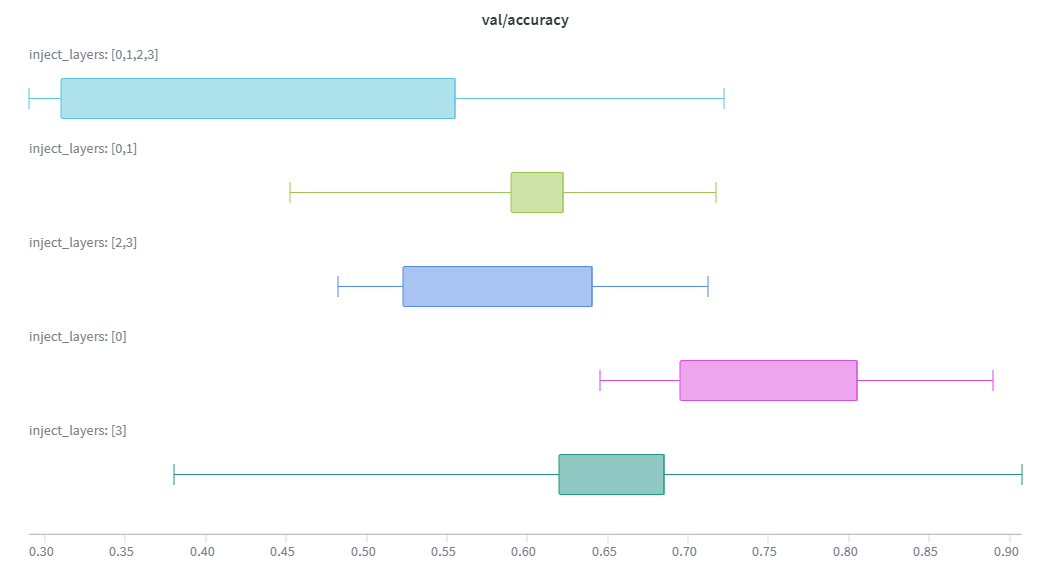

Sweep results show that the HTSAT layers in which ResiDual is injected highly influence the final accuracy on the test set.

Applying  ResiDual only on the **first layer** gives the best performance, suggesting that the ResiDual rescaling action is more effective when acting on the early attention outputs, which are general and highly localized. Moreover, the HTSAT hierarchical architecture progressively aggregates them across layers, propagating the effect of the initial ResiDual modulation.

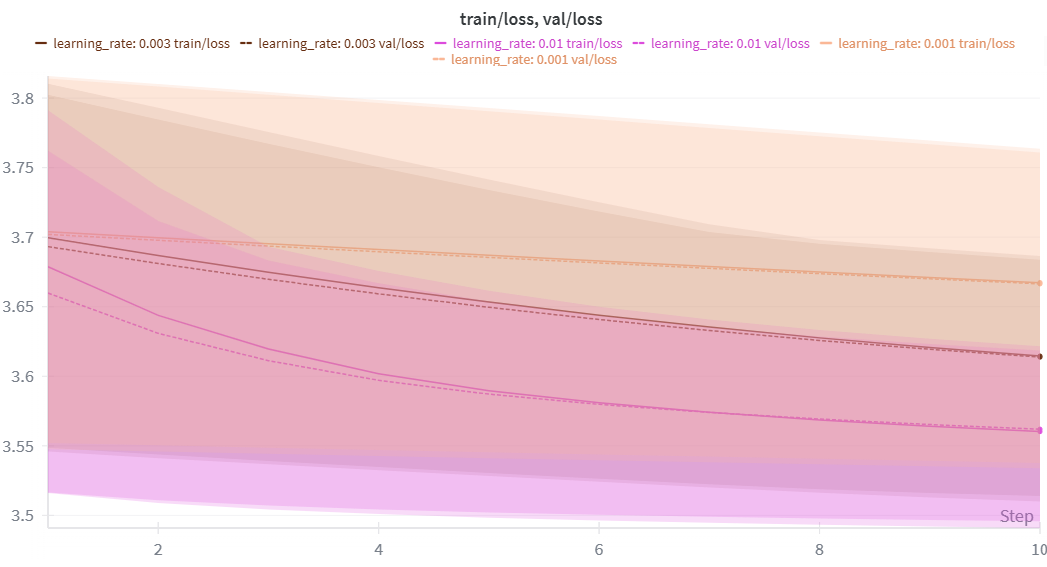

Setting **learning rate = 0.01** provides the fastest optimization, thus it will be used in the subsequent notebook training process.